# homework 2

#### Dominik Pegler  
#### 2022-05-03

Due: May 8 2022

## Assignment

In this homework you have to show two things. On the one hand that you understand what a good diagram is and on the other hand that you have the technical skills to create such diagrams with ggplot2.

Therefore, at the beginning of a task there is the goal that the diagram should achieve, followed by more concrete instructions. The exact implementation is not given and also depends somewhat on your data set. Pay attention to labels, the choice of colors and other visual details (background etc.), but in any case make sure that your diagram achieves the goal. You can use the attached sample charts as a guide.

This homework builds on the 1st homework, so work with the data from your data set processed according to the first homework. The relevant experimental conditions are the same as in the 1st homework (All factor combination of targetValidity and the cue condition [different name depending on the dataset]). Please get in touch in time if there are problems or exchange ideas in the forum.

## Import data and join individual text files

In [8]:
library(ggplot2)
theme_set(theme_minimal())
update_geom_defaults("bar", list(fill = "steelblue"))
library(viridis)

filelist = list.files(pattern = ".*.txt")
datalist = lapply(filelist, function(x)read.table(x, header=T)) 
df <- do.call("rbind", datalist)

In [9]:
head(df)

cueSize,targetValidity,sbj,gender,age,answerCorrect,reactionTime
big,valid,1,man,24,1,0.8324752
small,valid,1,man,24,1,0.9231140
big,valid,1,man,24,1,0.7467758
small,valid,1,man,24,1,0.6237159
big,valid,1,man,24,1,0.3630229
small,valid,1,man,24,1,0.7806121


In [10]:
# keep only correct answers and realistic reaction times as done in homework 1
df_correct <- df[df$answerCorrect==1 & df$reactionTime<=1 & df$reactionTime >= 0.15,]

## Plot 1

Generate a graph that shows the correct reaction time distribution of each subject in each relevant experimental condition. Use violin diagrams and plot all conditions in one diagram (see diagram A of the example diagrams).

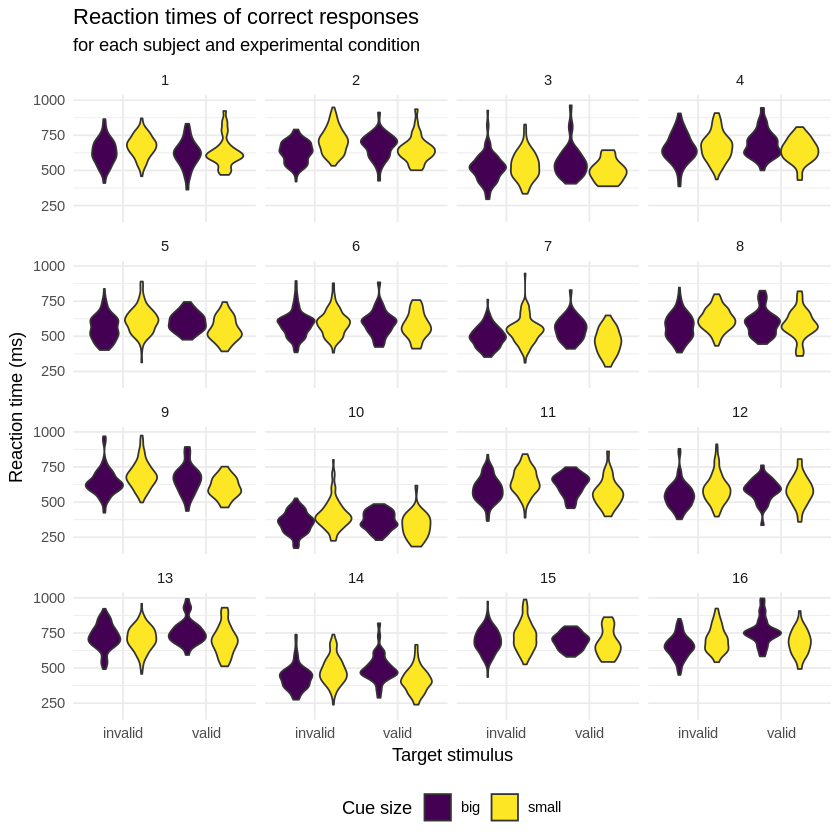

In [23]:
ggplot(df_correct, aes(x = targetValidity, y = reactionTime * 1000, fill = cueSize)) + 
  geom_violin() +
  facet_wrap(~ sbj) +
  labs(title = "Reaction times of correct responses",
       subtitle = "for each subject and experimental condition",
       x = "Target stimulus",
       y = "Reaction time (ms)",
       fill = "Cue size") +
       theme(legend.position = "bottom") + scale_fill_viridis_d()

## Plot 2
Generate a graph with the mean values of the reaction times of the correct responses of each relevant experimental condition including the standard errors as error bars. The mean values should be represented as points connected by a line through the variable targetValidity (see Diagram B of the example diagrams). In addition, the mean value should be shown as a rounded number in milliseconds in the diagram. Milliseconds should also be plotted on the axis instead of seconds.

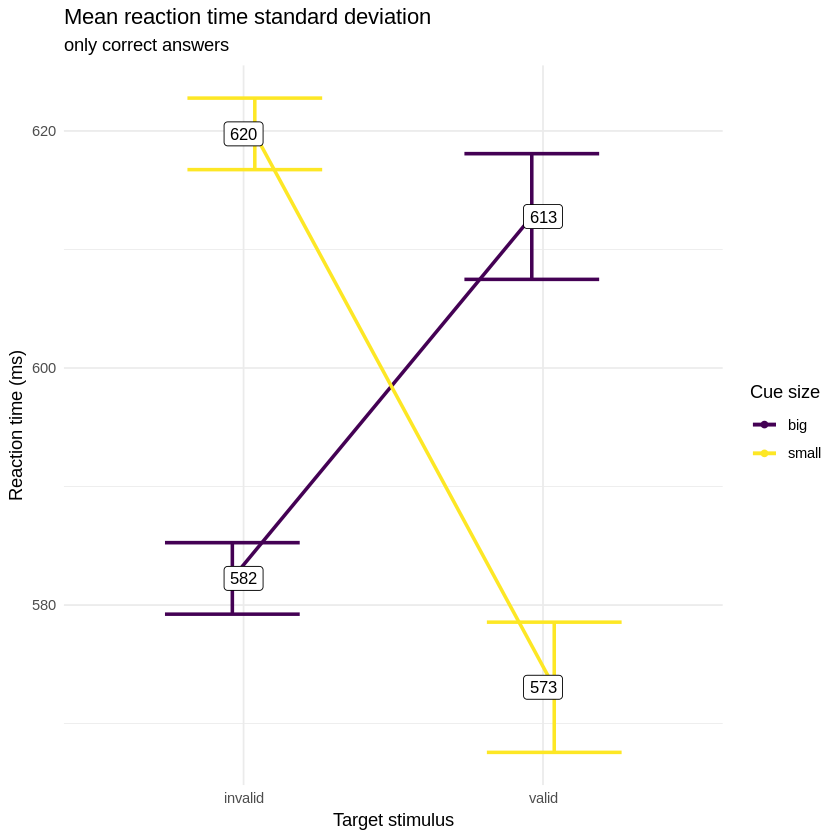

In [157]:
# df for plot # incl conversion to ms
df_a_mean <- aggregate(df_correct$reactionTime * 1000, list(df_correct$cueSize, df_correct$targetValidity), FUN=mean) 
df_a_sd <- aggregate(df_correct$reactionTime * 1000, list(df_correct$cueSize, df_correct$targetValidity), FUN=sd) 
df_a_n <- aggregate(df_correct$reactionTime * 1000, list(df_correct$cueSize, df_correct$targetValidity), FUN=length) 

names(df_a_sd)[3] <- "sd"
names(df_a_mean)[3] <- "mean"
names(df_a_n)[3] <- "n"
df_a <- merge(df_a_mean, df_a_sd)
df_a <- merge(df_a, df_a_n)
names(df_a)[1] <- "cueSize"
names(df_a)[2] <- "targetValidity"
df_a$se <- df_a$sd/sqrt(df_a$n) # std error

# plot
ggplot(df_a, aes(x=targetValidity, y = mean, group = cueSize, color = cueSize)) + 
    geom_line(size = 1, position=position_dodge(0.15)) +
    scale_color_viridis_d() +
    geom_point(position=position_dodge(0.15)) +
    geom_errorbar(aes(ymin = mean - se, ymax = mean + se),
                  size = 1,
                  position=position_dodge(0.15)) + 
    labs(
        title="Mean reaction time standard error",
        subtitle = "only correct answers",
        x = "Target stimulus",
        y = "Reaction time (ms)",
        color = "Cue size") + 

    geom_label(aes(label = round(df_a$mean)),
              size = 3.5, color = "black") 

## Plot 3

Generate the same diagram as in the 2nd task, but now with the mean validity effect (note that the validity effect must be calculated for each person in each condition so that there is then a mean with standard deviation) and the 95% confidence interval as an error bar. In addition, integrate the means of the subjects as points and plot the distribution of validity effects as a violin diagram. The validity effect in rounded milliseconds should be in the diagram and milliseconds should also be plotted on the axis. Additionally, draw a red horizontal line at 0 milliseconds. This line shows the absence of a validity effect, i.e., no attention capture (see Diagram C of the example diagrams).

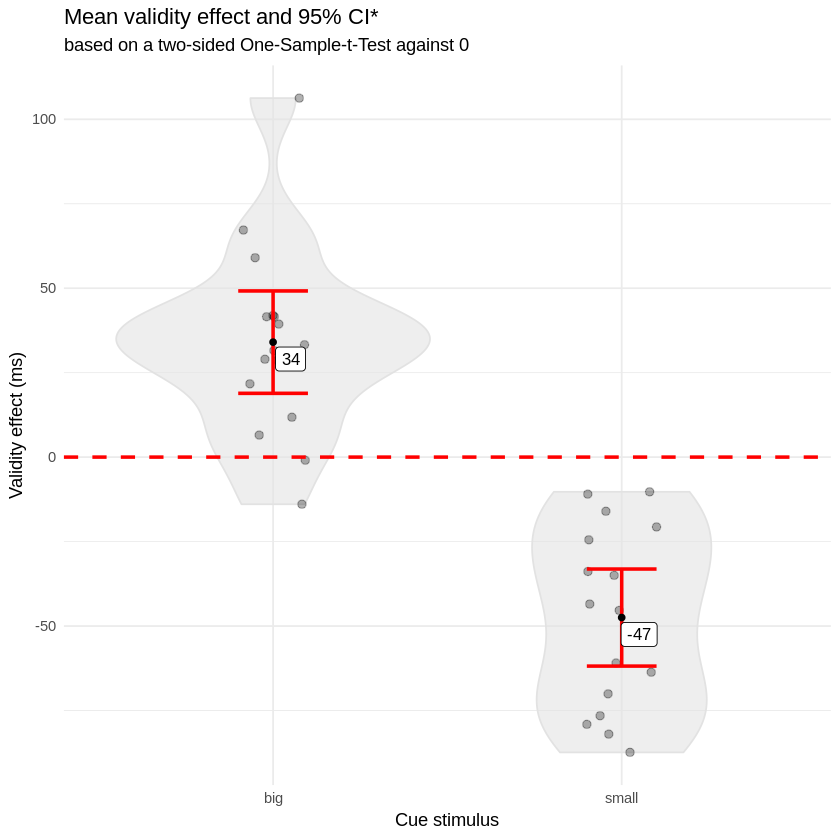

In [158]:
# df for plot (for violin and jitter and as base for aggregated df)
valid <- df_correct[df_correct$targetValidity=="valid",]
valid <- aggregate(valid$reactionTime, list(valid$sbj, valid$cueSize), FUN=mean) 

invalid <- df_correct[df_correct$targetValidity=="invalid",]
invalid <- aggregate(invalid$reactionTime, list(invalid$sbj, invalid$cueSize), FUN=mean) 

names(invalid) <- c("sbj", "cueSize", "reactionTime_invalid")
names(valid) <- c("sbj", "cueSize", "reactionTime_valid")

df_val <- merge(valid, invalid)
df_val$validityEffect <- df_val$reactionTime_valid - df_val$reactionTime_invalid

df_val$validityEffect <- df_val$validityEffect * 1000 # ms

# aggregated df for plot
df_a_val_mean <- aggregate(df_val$validityEffect, list(df_val$cueSize), FUN=mean) 
df_a_val_sd <- aggregate(df_val$validityEffect, list(df_val$cueSize), FUN=sd) 
df_a_val_n <- aggregate(df_val$validityEffect, list(df_val$cueSize), FUN = length) 
names(df_a_val_sd)[2] <- "sd"
names(df_a_val_mean)[2] <- "mean"
names(df_a_val_n)[2] <- "n"
df_a_val <- merge(df_a_val_mean, df_a_val_sd)
df_a_val <- merge(df_a_val, df_a_val_n)
df_a_val$CI_margin <- qt(0.975, df = (df_a_val$n - 1)) * df_a_val$sd / sqrt(df_a_val$n) # 95% CI 2-sided
names(df_a_val)[1] <- "cueSize"

# plot
ggplot(data = df_a_val, aes(x = cueSize, y = mean)) + 
    geom_violin(data = df_val, aes(y = validityEffect, x = cueSize), trim=TRUE, fill = "#e2e2e2", color = "#e2e2e2", alpha = 0.6) +
    geom_jitter(data = df_val, aes(y = validityEffect, x = cueSize), alpha = 0.3, size = 2, position=position_jitter(0.1)) +
    geom_errorbar(data = df_a_val, aes(ymin = mean - (CI_margin), ymax = mean + (CI_margin)),
                  size = 1, color = "red", width = 0.2) + 
    geom_point() +
    labs(
        title="Mean validity effect and 95% CI*",
        subtitle = "based on a two-sided One-Sample-t-Test against 0",
        x = "Cue stimulus",
        y = "Validity effect (ms)",
        color = "Cue size") + 
    geom_label(aes(label = round(df_a_val$mean)),
              size = 3.5, color = "black", nudge_x = .05, nudge_y = -5) +
    geom_hline(yintercept = 0, linetype = "dashed", size = 1, color = "red")

## Plot 4
Generate a graph showing the number of trials with correct reaction times for each participant in the experimental conditions. To do this, use a bar graph and draw a black horizontal line at 30 trials (see Diagram D of the sample diagrams). Reason for this: Only when you have at least 30 to 40 trials in the relevant experimental conditions do you achieve reasonably adequate power with about 20 participants. And since wrong answers are excluded, it is good to visualize the number of remaining trials of each participant (see diagram D of the example diagrams).

## Plot 5 (Bonus)
Expand the diagram of task 2 and the mean reaction times per participant and plot the reaction time distribution using a violin diagram (see example diagram B-Bonus).